# 0. Introduction

The file contains the following sections:

1. Loading packages and data sets
2. Initial data inspection and construction of new features
3. Exploratory Data Analysis
4. Construction of the Target Feature
5. Modelling strategy and models
6. Discussion of useful additional data, design and deployment of the model, communication of model recommendations, and strategy of validation in real-life.
7. References



# 1. Loading packages and data sets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import requests
import seaborn as sns
from math import radians, sin, cos, sqrt, atan2
import geopandas as gpd
from shapely.geometry import Point
import random
from scipy import stats


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras import backend as K

In [2]:
# Load synthetic data
df = pd.read_csv("data/syn_data.csv")

In [3]:
# Load the shapefile data containing subdistricts' details
subdistricts = gpd.read_file("data/asumid_02062020_shp/t02_41_asum.shp")
subdistricts = subdistricts.to_crs('EPSG:4326')

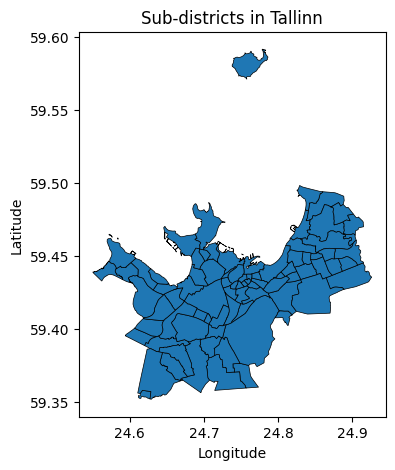

In [4]:
# Plot the subdistricts
subdistricts.plot(figsize=(6, 5), edgecolor='black', linewidth=0.5)
plt.title('Sub-districts in Tallinn')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


> **Note:**
> sub-districts will be used to construct the target.

# 2. Initial data inspection and construction of new features

In [5]:
df.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
0,2022-03-06 15:02:39.329452000,59.407910,24.689836,59.513027,24.831630,3.51825
1,2022-03-10 11:15:55.177526000,59.441650,24.762712,59.426450,24.783076,0.50750
2,2022-03-06 14:23:33.893257000,59.435404,24.749795,59.431901,24.761588,0.19025
3,2022-03-03 09:11:59.104192000,59.406920,24.659006,59.381093,24.641652,0.75600
4,2022-03-06 00:13:01.290346000,59.434940,24.753641,59.489203,24.876170,2.27100


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627210 entries, 0 to 627209
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   start_time  627210 non-null  object 
 1   start_lat   627210 non-null  float64
 2   start_lng   627210 non-null  float64
 3   end_lat     627210 non-null  float64
 4   end_lng     627210 non-null  float64
 5   ride_value  627210 non-null  float64
dtypes: float64(5), object(1)
memory usage: 28.7+ MB


In [7]:
# Convert 'start_time' column to datetime dtype
df['start_time'] = pd.to_datetime(df['start_time'])

# Extract year, month, day, time, weekday components, and construct 15 min and 30 min hour interval categories
df['year'] = df['start_time'].dt.year
df['month'] = df['start_time'].dt.month
df['day'] = df['start_time'].dt.day
df['time'] = df['start_time'].dt.time
df['hour'] = df['start_time'].dt.hour
df['minute'] = df['start_time'].dt.minute
df['hour_int_30'] = pd.cut(df['minute'], bins=[-1, 31, 60], labels=[1, 2], right=False)
df['weekday'] = df['start_time'].dt.strftime('%a')

> **Note:**
> The "hour_int_30" feature is crucial. Based on this feature, the target (demand) will be calculated for 30-minute intervals. Short-term predictions are necessary for car redirections.

In [8]:
# Check number of years, months, days, and weekdays
print('Number of years in dataset:', len(df['year'].unique()))
print('Number of months in dataset:', len(df['month'].unique()))
print('Number of days in dataset:', len(df['day'].unique()))
print('Number of weekdays in dataset:', len(df['weekday'].unique()))

Number of years in dataset: 1
Number of months in dataset: 1
Number of days in dataset: 28
Number of weekdays in dataset: 7


In [9]:
# Define function to calculate distance between start and end destinations using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    
    radius = 6371
    return c * radius

In [10]:
# Create 'ride_distance' feature using Haversine formula
df['ride_distance'] = haversine(df['start_lat'], df['start_lng'], df['end_lat'], df['end_lng'])
# Create ride_value/per kilometer
df['ride_value_per_km'] = df['ride_value']/df['ride_distance']


In [11]:
# Sort the data by 'day' and 'time'
df = df.sort_values(by=['day', 'time']).reset_index(drop=True)

In [12]:
# Inspect statistical properties of distributions of features.
df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
start_time,627210,2022-03-15 19:02:27.534693632,2022-03-01 00:00:07.936317,2022-03-09 00:03:53.773355008,2022-03-16 08:22:42.513948160,2022-03-22 21:30:09.320409600,2022-03-28 23:59:53.175658,NaN
start_lat,627210.0,59.428682,59.321557,59.418803,59.432069,59.439024,59.566998,0.021764
start_lng,627210.0,24.743468,24.505199,24.71314,24.744674,24.768115,24.973743,0.056872
end_lat,627210.0,59.397797,-37.819979,59.415215,59.430697,59.439262,61.552744,1.392755
end_lng,627210.0,24.724847,-122.453962,24.707919,24.744335,24.773924,144.96611,1.650709
ride_value,627210.0,2.261384,0.107628,0.54525,1.059,1.712,3172.701,44.889892
year,627210.0,2022.0,2022.0,2022.0,2022.0,2022.0,2022.0,0.0
month,627210.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0
day,627210.0,15.237287,1.0,9.0,16.0,22.0,28.0,8.03562
hour,627210.0,12.845851,0.0,8.0,14.0,18.0,23.0,6.44874


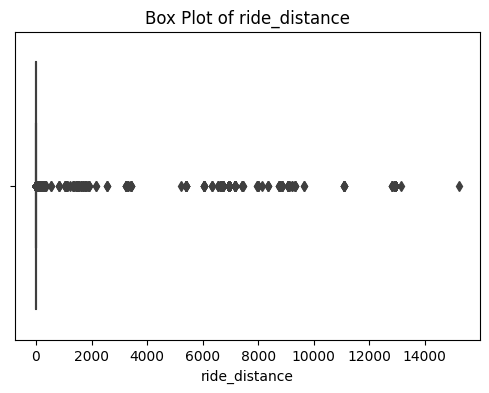

In [13]:
# Visualize the distribution of 'ride_distance'
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['ride_distance'])
plt.xlabel('ride_distance')
plt.title('Box Plot of ride_distance')
plt.show()

> **Note:**
> An outlier problem is present and it should be sorted out.

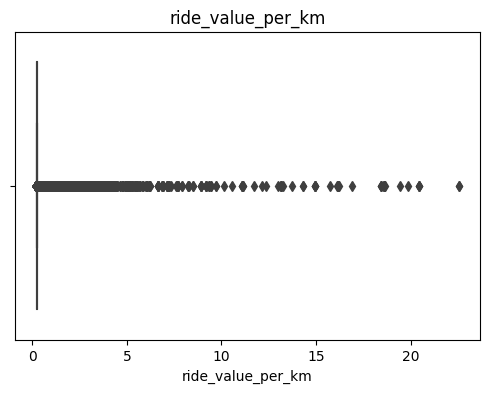

In [14]:
# Visualize the distribution of 'ride_value_per_km'
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['ride_value_per_km'])
plt.xlabel('ride_value_per_km')
plt.title('ride_value_per_km')
plt.show()

> **Note:** 
> Some data concerning ride_value_per_km appear untrustworthy due to outlier ride_values. However, I chose not to include this feature as part of the independent variable, thus bypassing this issue. By excluding this variable, I address the simultaneity (endogeneity) problem. Instead, I will use the ride_distance variable as a proxy for prices.

In [15]:
# Count the number of cases where ride_distance is above 20, 50, 100, and 150
num_above_20 = (df['ride_distance'] > 20).sum()
num_above_50 = (df['ride_distance'] > 50).sum()
num_above_100 = (df['ride_distance'] > 100).sum()
num_above_150 = (df['ride_distance'] > 150).sum()

print("Number of cases where ride_distance is above 20:", num_above_20)
print("Number of cases where ride_distance is above 50:", num_above_50)
print("Number of cases where ride_distance is above 100:", num_above_100)
print("Number of cases where ride_distance is above 150:", num_above_150)

Number of cases where ride_distance is above 20: 3209
Number of cases where ride_distance is above 50: 691
Number of cases where ride_distance is above 100: 614
Number of cases where ride_distance is above 150: 521


In [16]:
# Filter out rows where the ride_distance is above 20. 
df = df[df['ride_distance'] <= 20]

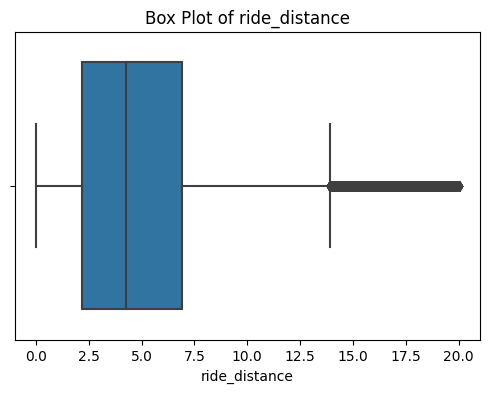

In [17]:
# visualize the distribution of 'ride_distance'
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['ride_distance'])
plt.xlabel('ride_distance')
plt.title('Box Plot of ride_distance')
plt.show()

In [18]:
print("The Data contains", len(df), "rows.")

The Data contains 624001 rows.


In [19]:
# Assign district and subdistrict names to start_lng and start_lat
geometry_start = [Point(xy) for xy in zip(df['start_lng'], df['start_lat'])]
geo_df_start = gpd.GeoDataFrame(df, geometry=geometry_start, crs='EPSG:4326') 
joined_start = gpd.sjoin(geo_df_start, subdistricts, how="left", predicate="within")
result_df_start = joined_start[['start_time', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'ride_value', 'year', 'month', 'day', 'time', 'hour', 'minute', 'hour_int_30',
       'weekday', 'ride_distance', 'ride_value_per_km', 'linnaosa_n', 'asumi_nimi']]

result_df_start = result_df_start.rename(columns={'asumi_nimi': 'subdistrict_start', 'linnaosa_n':'district_start'})

In [20]:
# Assign district and subdistrict names to end_lng and end_lat
geometry_end = [Point(xy) for xy in zip(result_df_start['end_lng'], df['end_lat'])]
geo_df_end = gpd.GeoDataFrame(result_df_start, geometry=geometry_end, crs='EPSG:4326') 
joined_end = gpd.sjoin(geo_df_end, subdistricts, how="left", predicate="within")
data = joined_end[['start_time', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'ride_value', 'year', 'month', 'day', 'time', 'hour', 'minute', 'hour_int_30',
       'weekday', 'ride_distance', 'ride_value_per_km', 'subdistrict_start', 'district_start', 'linnaosa_n', 'asumi_nimi']]

data = data.rename(columns={'asumi_nimi': 'subdistrict_end', 'linnaosa_n':'district_end'})


In [21]:
data['weekday'] = data['weekday'].astype('category')
data['day'] = data['day'].astype('category')
data['hour'] = data['hour'].astype('category')

In [22]:
print('Number of sub-districts:', len(data['subdistrict_start'].unique()))
print('Number of districts:', len(data['district_start'].unique()))

Number of sub-districts: 84
Number of districts: 9


> **Note:**
> A number of pickup latitude and longitude pairs fall outside the city's designated range, making it impossible to assign them a sub-district. Therefore, they have been assigned an 'unidentified' status.

In [23]:
# fill missing values with 'unidentified'
data['subdistrict_start'].fillna('unidentified', inplace=True)
data['district_start'].fillna('unidentified', inplace=True)


# 3. Exploratory Data Analysis

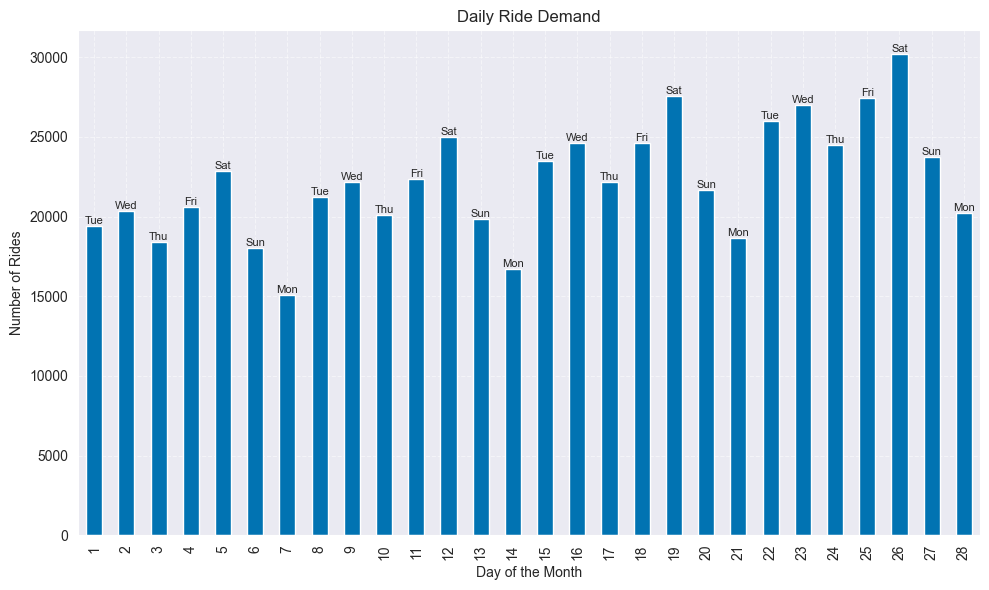

In [24]:
# aggregate ride demand by day of the month
day_demand = data.groupby('day').size()

sns.set_palette("colorblind")

sns.set_style("darkgrid")

plt.figure(figsize=(10, 6))
day_demand.plot(kind='bar')
plt.title('Daily Ride Demand')
plt.xlabel('Day of the Month')
plt.ylabel('Number of Rides')
plt.grid(axis='x', linestyle='--', alpha=0.5)  
plt.grid(axis='y', linestyle='--', alpha=0.5)  
plt.ylim(0)  
plt.xticks(np.arange(len(day_demand)), labels=day_demand.index)


for i, val in enumerate(day_demand.values):
    day_index = day_demand.index[i]
    weekday = df.loc[df['day'] == day_index, 'weekday'].iloc[0]
    plt.text(i, val, weekday, ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

> **Note:**
> Two important observations can be drawn from the graph above:
> 1. There is significant variation in the number of pickups across weekdays, with Monday being the least busy and Saturday being the busiest.
> 2. We observe an increasing trend across the weeks. Each weekday of the week is less busy than the same day in the following week. This trend could be a monthly pattern (for some reason, pickups are lower at the beginning of the month than at the end) or it might be part of a long-term increasing trend. With only one month of data, it is impossible to determine which observation is correct.

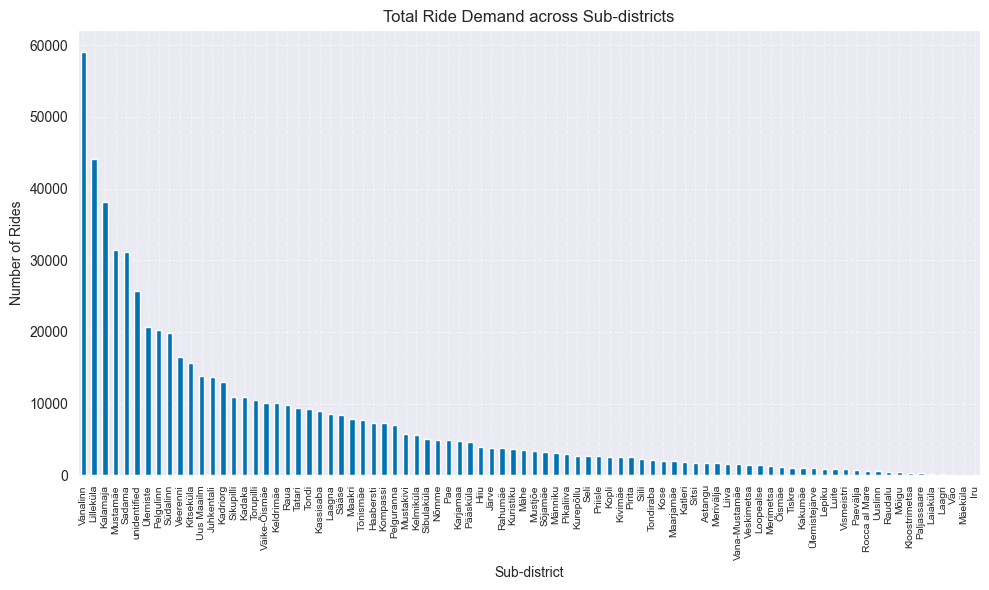

In [25]:
# Aggregate ride demand by sub-district
sub_district_demand_total = data.groupby('subdistrict_start').size()
sub_district_demand_total = sub_district_demand_total.sort_values(ascending=False)

sns.set_palette("colorblind")
sns.set_style("darkgrid")

plt.figure(figsize=(10, 6))
sub_district_demand_total.plot(kind='bar')
plt.title('Total Ride Demand across Sub-districts')
plt.xlabel('Sub-district')
plt.ylabel('Number of Rides')
plt.grid(axis='x', linestyle='--', alpha=0.5)  
plt.grid(axis='y', linestyle='--', alpha=0.5)  
plt.ylim(0)  


plt.xticks(rotation=90, fontsize=7.5)

plt.tight_layout()
plt.show()

> **Note:**
> There is significant variation in pickups across sub-districts. The variations in pickups across weekdays and sub-districts appear to be two important variables in predicting future pickups across space and time.

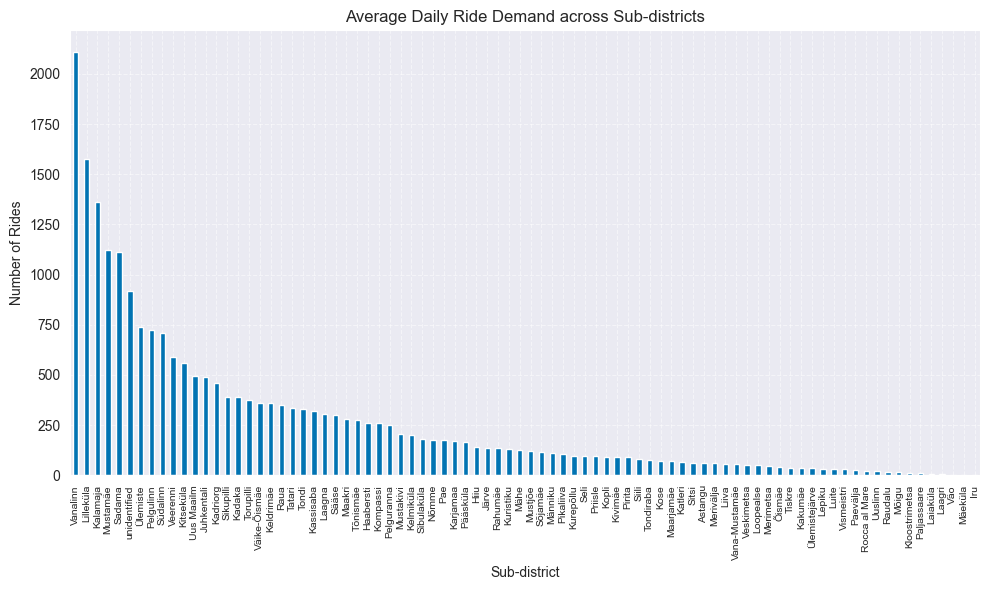

In [26]:
# average daily ride demand by sub-district
sub_district_demand_average = data.groupby('subdistrict_start').size()/28
sub_district_demand_average = sub_district_demand_average.sort_values(ascending=False)


sns.set_palette("colorblind")
sns.set_style("darkgrid")

plt.figure(figsize=(10, 6))
sub_district_demand_average.plot(kind='bar')
plt.title('Average Daily Ride Demand across Sub-districts')
plt.xlabel('Sub-district')
plt.ylabel('Number of Rides')
plt.grid(axis='x', linestyle='--', alpha=0.5)  
plt.grid(axis='y', linestyle='--', alpha=0.5)  
plt.ylim(0)  


plt.xticks(rotation=90, fontsize=7.5)

plt.tight_layout()
plt.show()

> **Note:**
> The average daily ride demand simply indicates the magnitude of daily pickups across sub-districts.

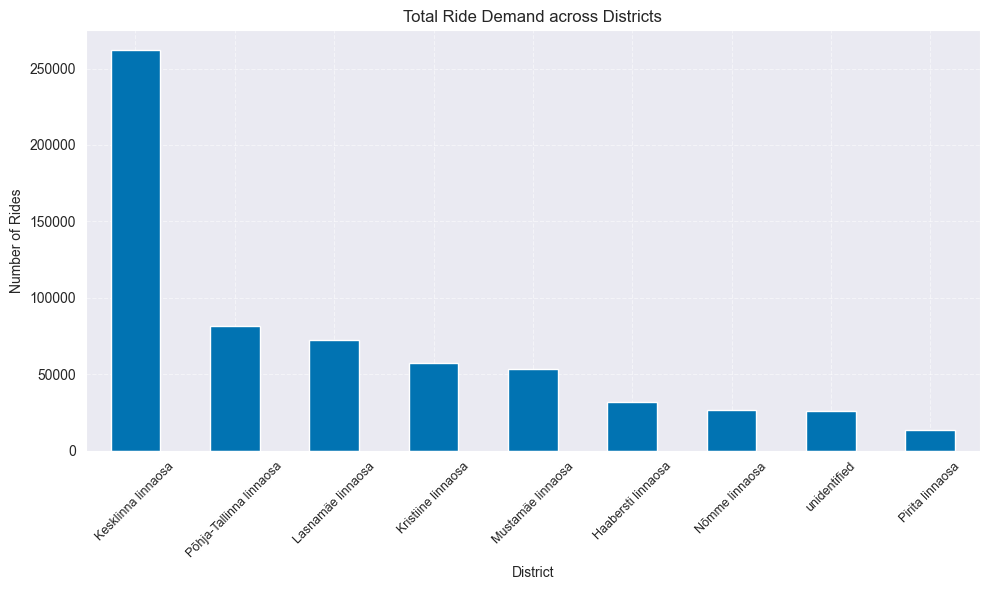

In [27]:
# aggregate ride demand by sub-district
district_demand_total = data.groupby('district_start').size()
district_demand_total = district_demand_total.sort_values(ascending=False)

sns.set_palette("colorblind")
sns.set_style("darkgrid")

plt.figure(figsize=(10, 6))
district_demand_total.plot(kind='bar')
plt.title('Total Ride Demand across Districts')
plt.xlabel('District')
plt.ylabel('Number of Rides')
plt.grid(axis='x', linestyle='--', alpha=0.5)  
plt.grid(axis='y', linestyle='--', alpha=0.5)  
plt.ylim(0)  

plt.xticks(rotation=45, fontsize=9)

plt.tight_layout()
plt.show()

> **Note:**
> One could potentially use aggregation at the district level, but sub-districts capture more information due to the extensive variation in pickups across sub-districts. Additionally, dividing the city into equal grids is another possibility, but I believe sub-districts provide more detailed information about the particularities of the space, including socio-economic variables of the people living in specific districts, and characteristics of the sub-districts (such as residential or business areas, trendy living spaces, etc.).

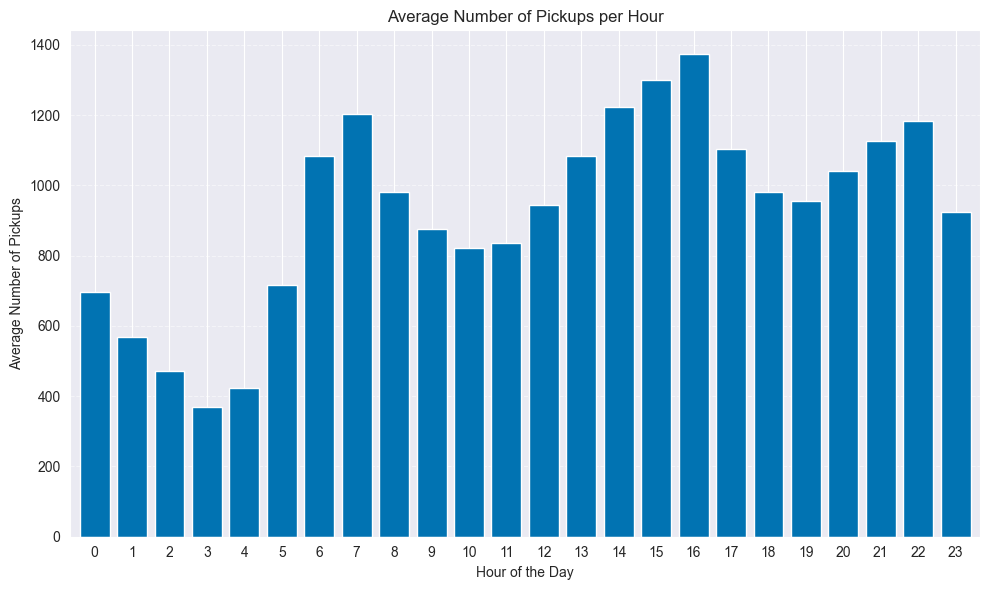

In [28]:
# Average ride demand by hour
hourly_demand = data.groupby('hour').size() / 28  

sns.set_palette("colorblind")
sns.set_style("darkgrid")

plt.figure(figsize=(10, 6))
hourly_demand.plot(kind='bar', width=0.8)
plt.title('Average Number of Pickups per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Pickups')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

> **Note:**
> The graph above demonstrates that the hour of the day is another important factor in explaining variations in pickups. The busiest part of the day is between 14:00 and 16:00, while the least busy hours are during the early morning.

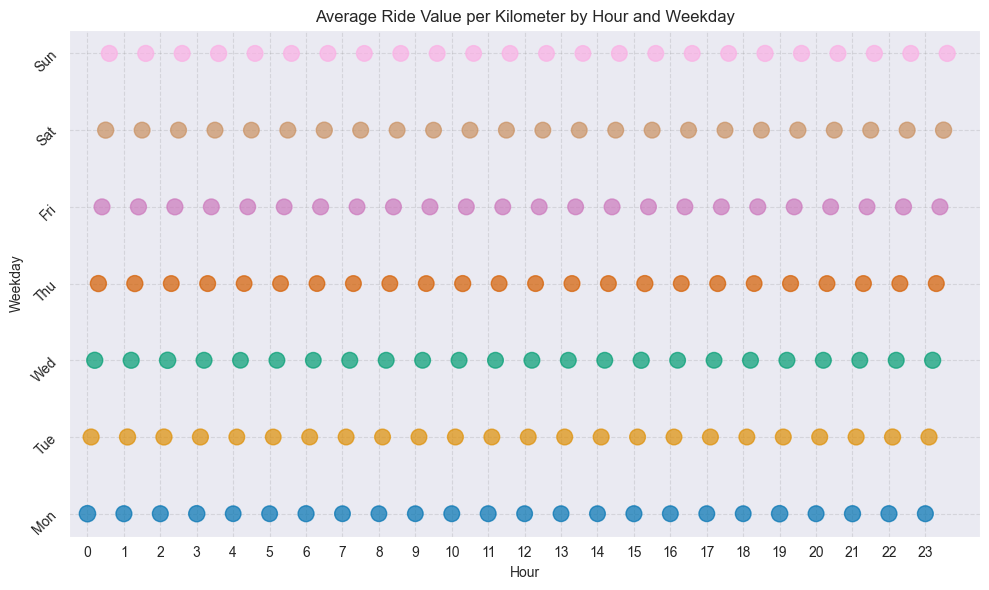

In [29]:
# Average Ride Value per Kilometer by Hour and Weekday
color_palette = sns.color_palette("colorblind")
plt.figure(figsize=(10, 6))
ax = plt.gca()

avg_data = data.groupby(['weekday', 'hour'])['ride_value_per_km'].mean().reset_index()
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
weekday_mapping = {weekday: i for i, weekday in enumerate(weekdays)}

for i, weekday in enumerate(weekdays):
    weekday_data = avg_data[avg_data['weekday'] == weekday].copy()
    weekday_data.loc[:, 'weekday_num'] = weekday_data['weekday'].map(weekday_mapping)
    weekday_data.loc[:, 'hour_num'] = weekday_data['hour'].astype(int)
    x_coords = weekday_data['hour_num'] + 0.1 * i
    ax.scatter(x_coords, weekday_data['weekday_num'],
               s=weekday_data['ride_value_per_km'] * 500,
               label=weekday, alpha=0.7)

plt.title('Average Ride Value per Kilometer by Hour and Weekday')
plt.ylabel('Weekday')
plt.xlabel('Hour')

yticks_int = range(len(weekdays))
plt.yticks(yticks_int, weekdays, rotation=45)
plt.grid(True, linestyle='--', alpha=0.2, color='gray')

plt.xlim(-0.5, 24.5)
plt.xticks(range(24))
plt.grid(True)
plt.tight_layout()
plt.show()

> **Note:**
> The average ride value per km graph suggests that there is no significant difference in pricing across weekdays and hours. It's quite clear that this observation diverges from reality. 

> **Concluding Remarks:**
>
> It appears that variations in weekday, across sub-districts, and hour of the day pickups are crucial features that can predict future pickups across space and time. I intend to leverage all these features in the model-building process. Additionally, while demand is typically 'determined' by prices according to economic textbooks, there exists a serious endogeneity problem. Therefore, I will use the distance of the ride as a proxy for prices, as prices and distance are correlated.

# 4. Construction of the Target Feature

### The target is calculated at each sub-district level for each day and hour within 30-minute intervals.

In [30]:
# Grouping the data by 'subdistrict_start', 'day', 'hour', 'hour_int_30', target is calculated at this level of aggregation - 30 min interval
data_baseline_30 = data.groupby(['subdistrict_start', 'day', 'hour', 'hour_int_30']).agg(
    target=('start_time', 'size'),  
    avg_ride_value=('ride_value', 'mean'),
    avg_ride_distance=('ride_distance', 'mean'),
    avg_ride_value_per_km=('ride_value_per_km', 'mean'),
    weekday=('weekday', 'first') 
).reset_index()

data_baseline_30['target'] = data_baseline_30.groupby(['subdistrict_start', 'day', 'hour', 'hour_int_30'])['target'].transform(lambda x: x.fillna(0))
data_baseline_30['weekday'] = data_baseline_30.groupby(['subdistrict_start', 'day'])['weekday'].transform(lambda x: x.fillna(method='bfill').fillna(method='ffill'))

> **Note:**
> I keep 0 pickups as such information is valuable and the training model should see such observations.

In [31]:
# Fill NaN values in the following features with 0
data_baseline_30['avg_ride_value'].fillna(0, inplace=True)
data_baseline_30['avg_ride_distance'].fillna(0, inplace=True)
data_baseline_30['avg_ride_value_per_km'].fillna(0, inplace=True)

In [32]:
# check that we have full number of pickups
print('Total pickups baseline_30:', data_baseline_30['target'].sum())

Total pickups baseline_30: 624001


In [33]:
data_baseline_30.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
target,112896.0,5.527220,9.680427,0.0,0.0,2.000000,6.000000,193.000000
avg_ride_value,112896.0,1.062700,0.862463,0.0,0.0,1.034186,1.595920,4.938250
avg_ride_distance,112896.0,4.303709,3.496666,0.0,0.0,4.185608,6.463915,19.995954
avg_ride_value_per_km,112896.0,0.187060,0.122617,0.0,0.0,0.246439,0.247530,7.285676


In [34]:
# delete rows where subdistrict_start is not identified
data_baseline_30 = data_baseline_30[data_baseline_30['subdistrict_start'] != 'unidentified'].reset_index(drop=True)


> **Note:**
> Inclusion of an unidentified sub-district does not change the results.

In [35]:
# Arrange data - during training, the model should see every sub-district from the start date
data_baseline_30 = data_baseline_30.sort_values(by=['day', 'hour', 'hour_int_30']).reset_index(drop=True)

> **Note:**
> This step is important because the data includes a time dimension. We want the model to see older data for each sub-district while training and for the test data to contain the latest available data for all sub-districts. This way, we make sure that we are producing predictions for the latest data available.

In [36]:
print(len(data_baseline_30['subdistrict_start'].unique()))
print(len(data_baseline_30['day'].unique()))

83
28


In [37]:
data_baseline_30['hour'] = data_baseline_30['hour'].astype(int)
# Transform hour feature using cyclical encoding to account for the hour.
data_baseline_30['hour_sin'] = np.sin(2 * np.pi * data_baseline_30['hour'] / 24)
data_baseline_30['hour_cos'] = np.cos(2 * np.pi * data_baseline_30['hour'] / 24)

> **Note:**
> To account for the hour in the data generating process, I employ cyclical encoding. Instead of creating dummies for each hour, this approach results in the creation of two new features, reducing the number from 24 that would have been generated using the dummy approach - avoiding the potential "curse of dimensionality".

In [38]:
data_baseline_30.head(10)

,subdistrict_start,day,hour,hour_int_30,target,avg_ride_value,avg_ride_distance,avg_ride_value_per_km,weekday,hour_sin,hour_cos
0,Astangu,1,0,1,0,0.000000,0.000000,0.000000,Tue,0.0,1.0
1,Haabersti,1,0,1,5,1.002050,4.061866,0.247028,Tue,0.0,1.0
2,Hiiu,1,0,1,5,1.586600,6.412102,0.247201,Tue,0.0,1.0
3,Iru,1,0,1,0,0.000000,0.000000,0.000000,Tue,0.0,1.0
4,Juhkentali,1,0,1,3,1.267917,5.165557,0.245421,Tue,0.0,1.0
5,Järve,1,0,1,1,0.211250,0.846668,0.249508,Tue,0.0,1.0
6,Kadaka,1,0,1,3,1.870750,7.579135,0.246895,Tue,0.0,1.0
7,Kadriorg,1,0,1,4,2.041750,8.276073,0.246500,Tue,0.0,1.0
8,Kakumäe,1,0,1,1,2.254750,9.182671,0.245544,Tue,0.0,1.0
9,Kalamaja,1,0,1,31,0.855024,3.454714,0.250192,Tue,0.0,1.0


In [39]:
#  Create dummy variables
dummy_cols = ['subdistrict_start', 'weekday']
data_baseline_30 = pd.get_dummies(data_baseline_30, columns=dummy_cols)

> **Note:**
> Sub-district and weekday dummies will account for all factors that are specific to sub-districts and weekdays.

# 5. Modelling strategy and models

In [40]:
X = data_baseline_30.drop(columns=['target', 'avg_ride_value', 'hour_int_30', 'avg_ride_value', 'avg_ride_value_per_km', 'day','hour' ])  
y = data_baseline_30['target']

> **Note:**
> The set of features consists of: avg_ride_distance, hour_sin, hour_cos, sub-district dummies, and weekday dummies. The next step below ensures that the train-test split retains the time structure. The test data contains the latest available data.

In [41]:
# Split the data into training and testing sets without shuffling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False, random_state=42)

# Print the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (105974, 93)
X_test shape: (5578, 93)
y_train shape: (105974,)
y_test shape: (5578,)


> **Note:**
> A test size of 5% is adequate to generate predictions for a day and a half of data, covering every half-hour interval and every sub-district. Increasing the test size to 10% marginally degrades the results. Models will be assessed based on their capacity to predict demands every 30 minutes for each sub-district over a day and a half. The evaluation metrics used include MSE, R2, and adjusted R2.

In [42]:
# Count the number of zeros in y
num_zeros_train = np.count_nonzero(y_train == 0)
num_zeros_test = np.count_nonzero(y_test == 0)

print("Number of zeros in y_train:", num_zeros_train)
print("Number of zeros in y_test:", num_zeros_test)

Number of zeros in y_train: 27947
Number of zeros in y_test: 1428


### 5.1 Model 1 - Baseline - Linear Regressor

One could have opted for a naive baseline model, such as predicting based on the demand from the same sub-district, hour and hour interval 7 days ago. However, I chose to use linear regression instead. It should be noted that, as demonstrated by the EDA, the data is highly non-linear even at the aggregate level.

In [43]:
# Model 1 - Baseline - linear Regression
model = LinearRegression()

model.fit(X_train, y_train)
y_train_pred_lr = model.predict(X_train)
y_test_pred_lr = model.predict(X_test)

train_mse_lr = mean_squared_error(y_train, y_train_pred_lr)
test_mse_lr = mean_squared_error(y_test, y_test_pred_lr)
train_r2_lr = r2_score(y_train, y_train_pred_lr)
test_r2_lr = r2_score(y_test, y_test_pred_lr)

num_predictors = X_train.shape[1]
train_adjusted_r2_lr = 1 - (1 - train_r2_lr) * (len(y_train) - 1) / (len(y_train) - num_predictors - 1)
test_adjusted_r2_lr = 1 - (1 - test_r2_lr) * (len(y_test) - 1) / (len(y_test) - num_predictors - 1)

print("Linear Regressor Results:")
print("Training MSE:", round(train_mse_lr, 4))
print("Testing MSE:", round(test_mse_lr, 4))
print("Training R^2:", round(train_r2_lr, 4))
print("Testing R^2:", round(test_r2_lr, 4))
print("Training Adjusted R^2:", round(train_adjusted_r2_lr, 4))
print("Testing Adjusted R^2:", round(test_adjusted_r2_lr, 4))

Linear Regressor Results:
Training MSE: 32.4367
Testing MSE: 38.6944
Training R^2: 0.6436
Testing R^2: 0.6164
Training Adjusted R^2: 0.6433
Testing Adjusted R^2: 0.6099


> **Note:**
> MSE is quite high, and the adjusted R-squared is relatively low. Considering the inclusion of many dummy variables, it is evident that the linear regressor does not yield satisfactory results.

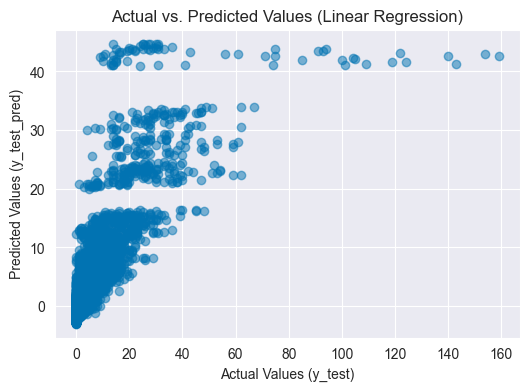

In [44]:
# Actual vs. predicted values - Linear Regressor
color_palette = sns.color_palette("colorblind")
sns.set_style("darkgrid")

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_test_pred_lr, alpha=0.5, color=color_palette[0])
plt.title("Actual vs. Predicted Values (Linear Regression)")
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_test_pred)")
plt.show()

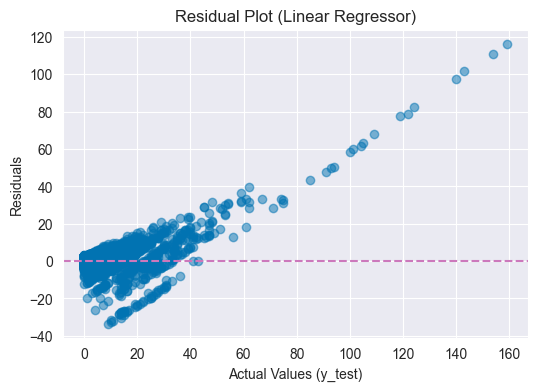

In [45]:
# Residuals - Linear Regressor
residuals_lr = y_test - y_test_pred_lr

color_palette = sns.color_palette("colorblind")
sns.set_style("darkgrid")

plt.figure(figsize=(6, 4))
plt.scatter(y_test, residuals_lr, alpha=0.5, color=color_palette[0])
plt.axhline(y=0, color=color_palette[4], linestyle='--')  
plt.title("Residual Plot (Linear Regressor)")
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Residuals")
plt.show()

> **Note:**
> It is evident that the normality assumption of errors, which is crucial for linear regression, is violated in the data.

### 5.2 Model 2 - ExtraTrees Regressor

To address the non-linearity of the data, I opt for the classical machine learning tool, the ExtraTrees regressor.

In [46]:
# Model 2 - ExtraTreesRegressor 
extra_trees_model = ExtraTreesRegressor(
    n_estimators=500, 
    max_depth=None,  
    min_samples_split=5,  
    min_samples_leaf=2,  
    max_features=None,  
    bootstrap=True,  
    random_state=42
)


extra_trees_model.fit(X_train, y_train)

y_train_pred_extra_trees = extra_trees_model.predict(X_train)
y_test_pred_extra_trees = extra_trees_model.predict(X_test)

train_mse_extra_trees = mean_squared_error(y_train, y_train_pred_extra_trees)
test_mse_extra_trees = mean_squared_error(y_test, y_test_pred_extra_trees)
train_r2_extra_trees = r2_score(y_train, y_train_pred_extra_trees)
test_r2_extra_trees = r2_score(y_test, y_test_pred_extra_trees)

train_adjusted_r2_extra_trees = 1 - (1 - train_r2_extra_trees) * (len(y_train) - 1) / (len(y_train) - num_predictors - 1)
test_adjusted_r2_extra_trees = 1 - (1 - test_r2_extra_trees) * (len(y_test) - 1) / (len(y_test) - num_predictors - 1)

print("ExtraTreesRegressor Results:")
print("Training MSE:", round(train_mse_extra_trees, 4))
print("Testing MSE:", round(test_mse_extra_trees, 4))
print("Training R^2:", round(train_r2_extra_trees, 4))
print("Testing R^2:", round(test_r2_extra_trees, 4))
print("Training Adjusted R^2:", round(train_adjusted_r2_extra_trees, 4))
print("Testing Adjusted R^2:", round(test_adjusted_r2_extra_trees, 4))

ExtraTreesRegressor Results:
Training MSE: 4.6539
Testing MSE: 9.6253
Training R^2: 0.9489
Testing R^2: 0.9046
Training Adjusted R^2: 0.9488
Testing Adjusted R^2: 0.903


> **Note:**
> The ExtraTrees Regressor provides a significant improvement over the Linear Regression Model. Further enhancement can be achieved by designing a simple grid search algorithm to find the optimal hyperparameters for the model. 

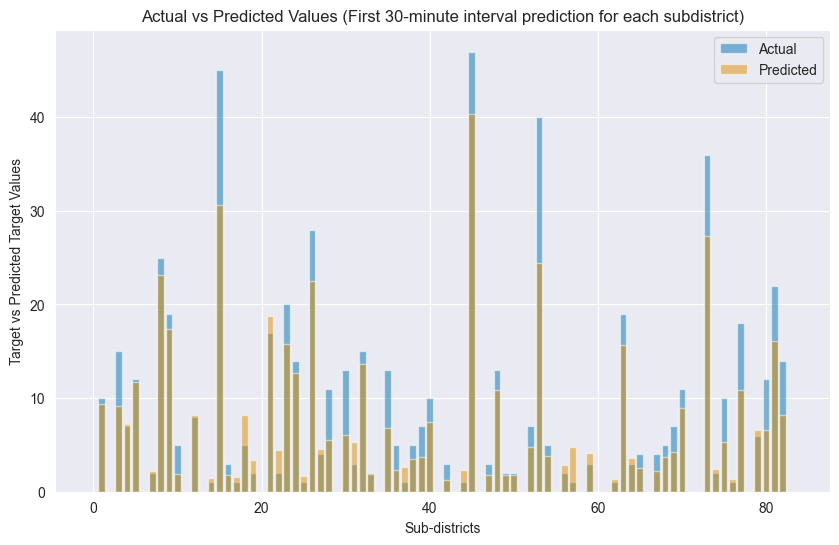

In [47]:
# Prediction of the first 83 observations (half-hour interval prediction for all sub-district)
y_test_first_83 = y_test[:83]
y_test_pred_extra_trees_first_83 = y_test_pred_extra_trees[:84]

color_palette = sns.color_palette("colorblind")


plt.figure(figsize=(10, 6))
plt.bar(range(len(y_test_first_83)), y_test_first_83, alpha=0.5, color=color_palette[0], label='Actual')
plt.bar(range(len(y_test_pred_extra_trees_first_83)), y_test_pred_extra_trees_first_83, alpha=0.5, color=color_palette[1], label='Predicted')
plt.xlabel('Sub-districts')
plt.ylabel('Target vs Predicted Target Values')
plt.title('Actual vs Predicted Values (First 30-minute interval prediction for each subdistrict)')
plt.legend()
plt.show()

> **Note**
> The graph above represents the actual versus predicted target values for the first 83 observations in the test data, showcasing the prediction error for all sub-districts in the first 30-minute interval. 

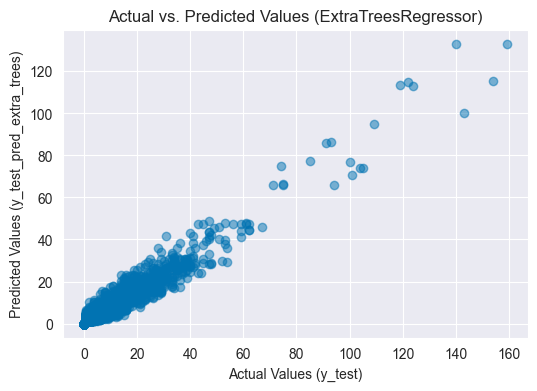

In [48]:
# Actual vs. predicted values - ExtraTreesRegressor
color_palette = sns.color_palette("colorblind")
sns.set_style("darkgrid")

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_test_pred_extra_trees, alpha=0.5, color=color_palette[0])
plt.title("Actual vs. Predicted Values (ExtraTreesRegressor)")
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_test_pred_extra_trees)")
plt.show()

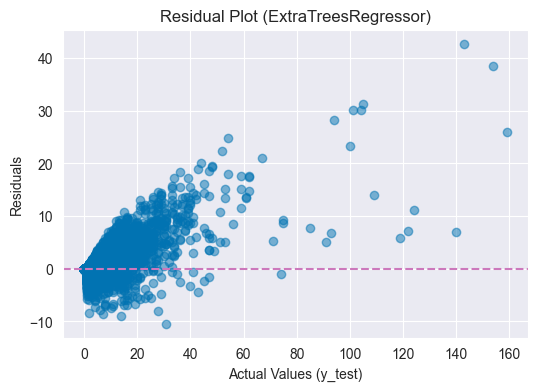

In [49]:
# Residuals - ExtraTreesRegressor
residuals_extra_trees = y_test - y_test_pred_extra_trees

color_palette = sns.color_palette("colorblind")
sns.set_style("darkgrid")

plt.figure(figsize=(6, 4))
plt.scatter(y_test, residuals_extra_trees, alpha=0.5, color=color_palette[0])
plt.axhline(y=0, color=color_palette[4], linestyle='--')  
plt.title("Residual Plot (ExtraTreesRegressor)")
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Residuals")
plt.show()

> **Note:**
> The model tends to underpredict demand more frequently. It appears that certain specific features are involved in the data generation process , which are not accounted for here. Further discussion on this issue follows in section 6.

### 5.3  Model 3 - GradientBoosting Regressor

A few months ago, I was browsing through the Kaggle AI Report of 2023, and I recall (hopefully correctly) that the Gradient Boosting regressor remains a potent classical machine learning tool in time series-related competitions. Even though this isn't a typical time series prediction exercise, out of curiosity, I designed a simple model, which, albeit slightly, underperforms compared to the ExtraTrees Regressor.

In [50]:
# Model 3 - GradientBoostingRegressor model 
gradient_boost_model = GradientBoostingRegressor(
    loss='squared_error',           
    learning_rate=0.1,   
    n_estimators=500,    
    subsample=1.0,       
    criterion='friedman_mse',  
    min_samples_split=2,        
    min_samples_leaf=1,         
    max_depth=6,               
    max_features=None,          
    random_state=42            
)

gradient_boost_model.fit(X_train, y_train)


y_train_pred_gb = gradient_boost_model.predict(X_train)
y_test_pred_gb = gradient_boost_model.predict(X_test)

train_mse_gb = mean_squared_error(y_train, y_train_pred_gb)
test_mse_gb = mean_squared_error(y_test, y_test_pred_gb)
train_r2_gb = r2_score(y_train, y_train_pred_gb)
test_r2_gb = r2_score(y_test, y_test_pred_gb)

train_adjusted_r2_gb = 1 - (1 - train_r2_gb) * (len(y_train) - 1) / (len(y_train) - num_predictors - 1)
test_adjusted_r2_gb = 1 - (1 - test_r2_gb) * (len(y_test) - 1) / (len(y_test) - num_predictors - 1)

print("Gradient Boosting Regressor Results:")
print("Training MSE:", round(train_mse_gb, 4))
print("Testing MSE:", round(test_mse_gb, 4))
print("Training R^2:", round(train_r2_gb, 4))
print("Testing R^2:", round(test_r2_gb, 4))
print("Training Adjusted R^2:", round(train_adjusted_r2_gb, 4))
print("Testing Adjusted R^2:", round(test_adjusted_r2_gb, 4))

Gradient Boosting Regressor Results:
Training MSE: 5.6808
Testing MSE: 10.0135
Training R^2: 0.9376
Testing R^2: 0.9007
Training Adjusted R^2: 0.9375
Testing Adjusted R^2: 0.899


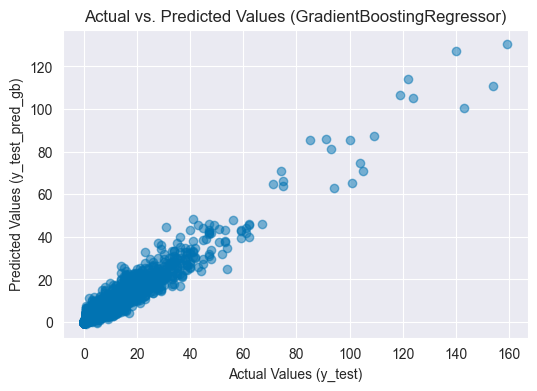

In [51]:
# Actual vs. predicted values - GradientBoostingRegressor
color_palette = sns.color_palette("colorblind")
sns.set_style("darkgrid")

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_test_pred_gb, alpha=0.5, color=color_palette[0])
plt.title("Actual vs. Predicted Values (GradientBoostingRegressor)")
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_test_pred_gb)")
plt.show()

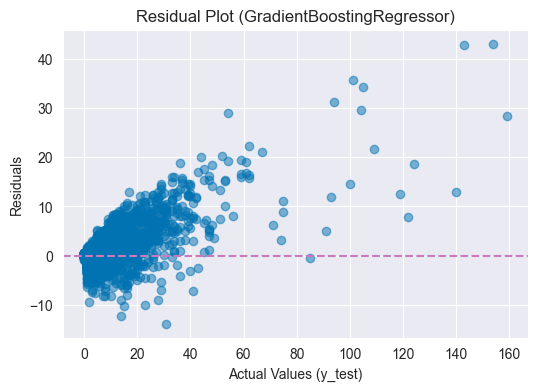

In [52]:
# Residuals - GradientBoostingRegressor
residuals_gb = y_test - y_test_pred_gb
sns.set_palette("colorblind")
sns.set_style("darkgrid")

plt.figure(figsize=(6, 4))
plt.scatter(y_test, residuals_gb, alpha=0.5, color=color_palette[0])
plt.axhline(y=0, color=color_palette[4], linestyle='--')  
plt.title("Residual Plot (GradientBoostingRegressor)")
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Residuals")
plt.show()

### 5.4 Model 4 - Simple CNN

I designed a very simple CNN model to evaluate its potential. The model performs better than the linear regression model but is inferior to ExtraTrees or GradientBoosting Regressors. However, it should be noted that deep learning architectures are powerful when we have large datasets, which is not the case here.

In [53]:
# Splitting the data into training and validation sets. Note that the train data is further split.
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train, y_train, test_size=0.05, shuffle=False, random_state=42)

In [54]:
# Convert input data to float32
X_train_cnn = X_train_cnn.astype(np.float32)
X_val_cnn = X_val_cnn.astype(np.float32)

In [55]:
# Convert DataFrame to NumPy array and reshape input data for Conv1D
X_train_cnn = X_train_cnn.values.reshape(X_train_cnn.shape[0], X_train_cnn.shape[1], 1)
X_val_cnn = X_val_cnn.values.reshape(X_val_cnn.shape[0], X_val_cnn.shape[1], 1)

In [56]:
print(X_train_cnn.shape)

(100675, 93, 1)


In [57]:
# CNN model
model_cnn = Sequential()
model_cnn.add(Conv1D(4, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(4, activation='relu'))
model_cnn.add(Dense(1)) 

model_cnn.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 91, 4)             16        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 45, 4)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 180)               0         
                                                                 
 dense (Dense)               (None, 4)                 724       
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 745
Trainable params: 745
Non-tr

2024-05-31 13:27:22.060648: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-31 13:27:22.061754: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [58]:
def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - SS_res/(SS_tot + K.epsilon())

# Compile the model
model_cnn.compile(optimizer='adam', loss='mean_squared_error', metrics=[r_square])


In [64]:
# Training the model
np.random.seed(42)
tf.random.set_seed(42)
history = model_cnn.fit(X_train_cnn, y_train_cnn, epochs=20, batch_size=64, validation_data=(X_val_cnn, y_val_cnn))

Epoch 1/20
   1/1574 [..............................] - ETA: 4:26 - loss: 9.4485 - r_square: 0.9372

2024-05-31 13:34:50.733291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1573/1574 [============================>.] - ETA: 0s - loss: 18.6967 - r_square: 0.7254

2024-05-31 13:34:58.526207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1574/1574 [==============================] - 8s 5ms/step - loss: 18.6963 - r_square: 0.7184 - val_loss: 39.1962 - val_r_square: 0.7005
Epoch 2/20
1574/1574 [==============================] - 8s 5ms/step - loss: 18.6886 - r_square: -836.6957 - val_loss: 38.2638 - val_r_square: 0.7088
Epoch 3/20
1574/1574 [==============================] - 8s 5ms/step - loss: 18.5148 - r_square: 0.6844 - val_loss: 42.1575 - val_r_square: 0.6818
Epoch 4/20
1574/1574 [==============================] - 9s 5ms/step - loss: 18.4659 - r_square: 0.7238 - val_loss: 36.5722 - val_r_square: 0.7009
Epoch 5/20
1574/1574 [==============================] - 8s 5ms/step - loss: 18.3725 - r_square: 0.7279 - val_loss: 38.4151 - val_r_square: 0.7115
Epoch 6/20
1574/1574 [==============================] - 8s 5ms/step - loss: 18.3596 - r_square: 0.7277 - val_loss: 36.4610 - val_r_square: 0.7146
Epoch 7/20
1574/1574 [==============================] - 7s 5ms/step - loss: 18.2340 - r_square: 0.7270 - val_loss: 36.7310 - val_r_s

In [60]:
# Convert input data to float32
X_test_cnn = X_test.astype(np.float32)

In [61]:
# Convert Data to NumPy array and reshape input data for Conv1D
X_test_cnn = X_test_cnn.values.reshape(X_test_cnn.shape[0], X_test_cnn.shape[1], 1)

In [63]:
# Evaluate the model on the test set
test_loss_cnn, r2_cnn = model_cnn.evaluate(X_test_cnn, y_test)
y_pred_cnn = model_cnn.predict(X_test_cnn)
mse_cnn = mean_squared_error(y_test, y_pred_cnn)

print(f'Test MSE: {test_loss_cnn}')
print(f'Test R^2: {r2_cnn}')

175/175 [==============================] - 1s 3ms/step - loss: 23.4256 - r_square: 0.5123
Test MSE: 23.42562484741211
Test R^2: 0.5123134255409241


> **Concluding Remarks:**
>
> For the given synthetic data, the ExtraTrees Regressor produces the best predictions. As previously mentioned, employing a simple grid or random search algorithms can enhance the predictability of the model by searching for the optimal model hyperparameters within a reasonable parameter space. Once such a model is constructed, it will generate predictions for each sub-district for the next 30-minute interval. If the prediction for a particular sub-district exceeds the current number of cars in the nearby vicinity, a redirection mechanism can be activated to send recommendations to drivers regarding such opportunities.

# 6. Discussion of useful additional data, design and deployment of the model, communication of model recommendations, and strategy of validation in real-life.

## 6.1 Useful additional data

1. We've observed that for synthetic data, the model tends to underpredict. I'm confident this phenomenon will also manifest with real data if the model solely relies on the features available here. Incorporating weather data is crucial, as demand inevitably increases during unfavorable weather conditions. Therefore, integrating weather predictions into the model can enhance predictions by leveraging variations in weather across days.
2. Additionally, incorporating information about holidays can further improve predictions. The impact of holidays on demand is not straightforward. It can either decrease demand, or the opposite direction is also possible. In any case, controlling for holidays can improve model predictions.
3. Information regarding the availability of alternative modes of transportation in the sub-districts, including options such as 2-wheel ride rentals, is important. Sub-districts with numerous 2-wheel ride rental stations can potentially reduce the demand for car rides.
4. One can enhance model predictions by incorporating interaction terms between weather conditions and the availability of alternative transportation modes. For example, while rainy weather may make a bike a less appealing substitute for a car ride, in warmer weather, the substitutability of a bike for a car ride might increase. Including these interaction terms can improve the accuracy of the predictions.

## 6.2 Design, development and deployment of the model

### Design and development of the model

This Jupyter Notebook showcases my approach to model design and development. I will summarize the steps I believe are crucial in this process. Towards the end of this subsection, I will discuss one step that is specific to the problem at hand.

1. Initial inspection of the data at hand and identification of any additional data requirements and assessment of their availability.
2. Thorough exploratory data analysis to understand the data-generating process and identify potential features.
3. Identification of a baseline model and a few alternative models guided possibly by literature review dealing with similar problems.
3. Training and validation of the models, which can be referred to as internal validation of the models.
4. Identification of the most promising model for deployment.


Before deploying the model, it's beneficial to evaluate its performance using counterfactuals. This entails comparing real data with a hypothetical scenario where drivers completely follow the model's suggestions. By comparing average values of drivers' earnings in both real and counterfactual scenarios, the economic effectiveness of the predictive model can be assessed, assuming full compliance of the drivers to the model's predictions. However, it's important to note that in real life, full compliance may not occur. More details about this issue are discussed in section 6.4.

### Deployment of the model

To leverage real-time demand forecasting, a deployment strategy that prioritizes speed and continuous operation is essential. Such deployment strategy can encompass several key components:
1. Packaging the trained model and its dependencies into a container.
2. Deploying the containerized model as a microservice on a platform.
3. Connecting the microservice with the real-time data processing system for live data intake.
4. Building secure APIs to expose model predictions to the app.
5. Setting up monitoring and logging tools to track performance and identify issues.
6. Integrating version control and developing a rollback plan for unforeseen issues.
7. Implementing security best practices for API access and data encryption.
8. Designing autoscaling and caching mechanisms for optimal resource utilization and API response times.


The model can be deployed on a platform like Kubernetes, which can manage containerized applications regardless of the underlying infrastructure. 

## 6.3 Communicating recommendations to drivers

Proper communication of the recommendations with drivers is essential for the success of a predictive model in real life. Such communications can be carried out by integrating predictive insights into the driver app, displaying heat maps or specific recommendations for high-demand areas. Implementation of a notification system to alert drivers to immediate opportunities based on real-time expected demand spikes ensures the fast delivery of information to drivers. Determining how to deliver such information, how to frame notifications, and whether to accompany them with incentive schemes are empirical questions that can be addressed using the mechanism offered in the next, final sub-section.

## 6.4 Validation of the model in a real-life context

To validate the predictive model in a real-life context, I propose a field experiment involving at least three randomly selected groups of drivers. The first group, Treatment 1, will receive recommendations solely based on the model's predictions. The second group, Treatment 2, will receive these recommendations along with some form of incentive. The third group, the Control group, will continue under the existing operational framework. 

This experiment will last for one month, after which we will analyze the data to evaluate the treatments' effects compared to the control. The evaluation metrics will include average monthly income of drivers, average user satisfaction, and average waiting time across Treatment 1, Treatment 2, and the Control groups. 

By utilizing causal inference tools and rich pre-treatment driver data, along with various related pre and post data, we will accurately ascertain the real-life causal impact of deploying the predictive model. The development of the recommendations and the incentive scheme will be refined in collaboration with behavioral psychologists/economists to ensure their effectiveness and engagement. Despite the experiment's benign nature, It is crucial that the experiment's design strictly adheres to ethical guidelines, safeguarding the interests and well-being of all participants. 

The field experiment will not incur significant costs and will offer the best possible insights into the effectiveness of the predictive model and recommendation notification system.